# extract truth ground photons in ICESat with the help of ALS data

In [1]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import geopandas as gp
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
sys.path.append('my_functions')
from alongtrack_XYZ import *
from scipy import spatial

## ALS

In [2]:
# load as df
ground_laz = pd.read_hdf('../data/pointclouds/SAF_20220901_GT3R_7m_dissolved_noiseHAG_nn_df.hdf')
# flip so it starts at high relief like ICESat
ground_laz = ground_laz[::-1].reset_index()
# get alongtrack
ground_laz, rotation_data = get_atl_alongtrack_XYZ(ground_laz)
# set 0 of alongtrack to ICESat's alongtrack
ground_laz.alongtrack_XYZ = ground_laz.alongtrack_XYZ - ground_laz.alongtrack_XYZ.min()
# only ground photons
ground_laz = ground_laz[ground_laz.classification == 2]
print(len(ground_laz))

952491


In [3]:
ground_laz

,index,X,Y,Z,Intensity,Num_of_Returns,Return_Ratio,las_height,classification,crosstrack,alongtrack_XYZ
0,2218170,-13131914.38,4080653.49,1522.38,1264.0,2.0,1.0,0.0,2,0.000000e+00,361.512072
3,2218167,-13131913.74,4080653.37,1522.24,512.0,2.0,1.0,0.0,2,6.258078e-01,361.332170
4,2218166,-13131913.93,4080650.96,1520.28,2464.0,1.0,1.0,0.0,2,2.090703e-01,358.950883
5,2218165,-13131914.05,4080649.33,1519.42,2208.0,1.0,1.0,0.0,2,-6.432128e-02,357.339499
6,2218164,-13131912.85,4080649.54,1519.16,2640.0,1.0,1.0,0.0,2,1.150147e+00,357.435240
...,...,...,...,...,...,...,...,...,...,...,...
2218166,4,-13134769.20,4110746.29,783.53,3312.0,1.0,1.0,0.0,2,-2.706114e-01,30589.423164
2218167,3,-13134770.61,4110741.42,783.57,3984.0,1.0,1.0,0.0,2,-2.134205e+00,30584.708080
2218168,2,-13134770.96,4110740.48,783.57,3632.0,1.0,1.0,0.0,2,-2.571409e+00,30583.805333
2218169,1,-13134769.40,4110742.19,783.57,3232.0,1.0,1.0,0.0,2,-8.568981e-01,30585.360374


## ICESat

convert to epsg:3857 if not done yet

In [3]:
!ogr2ogr -t_srs epsg:3857 -s_srs epsg:4326 C:\Users\Franzi\Documents\Thesis\data\beams\SGM\SAF_20220901_DEMs_GT3R_intp_utm3857.shp C:\Users\Franzi\Documents\Thesis\data\beams\SGM\SAF_20220901_DEMs_GT3R_intp.shp 

c:\Users\Franzi\miniconda3\envs\icesat2\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
c:\Users\Franzi\miniconda3\envs\icesat2\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
c:\Users\Franzi\miniconda3\envs\icesat2\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


In [6]:
# load in as gdf
gdf = gp.read_file(f'../data/beams/SGM/SAF_20220901_DEMs_GT3R_intp_utm3857.shp')

# rename columns
gdf['X'] = gdf.geometry.x.tolist()
gdf['Y'] = gdf.geometry.y.tolist()
gdf.rename(columns={"PhH_navd88": "Z"}, inplace=True)

# get alongtrack based on ESPG:3857 CRS
gdf, rotation_data = get_atl_alongtrack_XYZ(gdf)
print(len(gdf))

74749


In [7]:
gdf

,level_0,index,Latitude,Longitude,Photon_Hei,geoid_floa,dem_1m_slp,alongtrack,corr_value,Z,dem_1m_nav,geometry,X,Y,crosstrack,alongtrack_XYZ
0,65189,1465798,34.382644,-117.965616,1593.746338,-31.456400,44.144913,0.000000,-0.701662,1625.904400,1626.788796,POINT (-13131872.345 4080298.225),-1.313187e+07,4.080298e+06,0.000000e+00,0.000000
1,65190,1465797,34.382644,-117.965616,1595.324829,-31.456400,44.144913,0.003101,-0.701659,1627.482888,1626.795020,POINT (-13131872.334 4080298.229),-1.313187e+07,4.080298e+06,1.121151e-02,0.003600
2,65191,1465799,34.382644,-117.965616,1596.407104,-31.456400,44.144913,0.005226,-0.701655,1628.565159,1626.799287,POINT (-13131872.327 4080298.233),-1.313187e+07,4.080298e+06,1.889818e-02,0.006069
3,65192,1465795,34.382644,-117.965616,1602.720825,-31.456400,44.144913,0.017400,-0.701652,1634.878877,1626.824254,POINT (-13131872.283 4080298.251),-1.313187e+07,4.080298e+06,6.374158e-02,0.020193
4,65193,1465800,34.382650,-117.965617,1595.209717,-31.456400,42.367153,0.715130,-0.701648,1627.367765,1626.555063,POINT (-13131872.418 4080299.092),-1.313187e+07,4.080299e+06,9.299847e-03,0.869771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74744,144066,1544671,34.609097,-117.991834,749.839539,-32.193001,0.782531,25225.151103,-0.696683,782.729222,782.888446,POINT (-13134790.829 4110885.124),-1.313479e+07,4.110885e+06,8.033752e-05,30725.819275
74745,144067,1544675,34.609104,-117.991834,749.403809,-32.193001,0.849551,25225.867456,-0.696683,782.293492,782.883212,POINT (-13134790.917 4110885.994),-1.313479e+07,4.110886e+06,-4.921397e-03,30726.693080
74746,144068,1544676,34.609104,-117.991834,749.800659,-32.193001,0.849551,25225.868233,-0.696683,782.690343,782.883230,POINT (-13134790.915 4110885.995),-1.313479e+07,4.110886e+06,-2.122606e-03,30726.693985
74747,144069,1544674,34.609104,-117.991834,749.871033,-32.193001,0.849551,25225.868371,-0.696683,782.760717,782.883233,POINT (-13134790.914 4110885.995),-1.313479e+07,4.110886e+06,-1.626279e-03,30726.694146


## set up arrays

In [9]:
xyz_als = ground_laz[['X', 'Y','Z', 'alongtrack_XYZ']].to_numpy()
xyz_icesat = gdf[['X', 'Y','Z', 'alongtrack_XYZ']].to_numpy()

In [10]:
# for 2D kdtree
xz_als = ground_laz[['alongtrack_XYZ', 'Z']].to_numpy()
xz_icesat = gdf[['alongtrack_XYZ', 'Z']].to_numpy()

#np.save('../data/ground/ML/xz_icesat.npy', xz_icesat)

In [11]:
# sort by ATD
xz_als = xz_als[xz_als[:,0].argsort()]
xz_als

array([[0.00000000e+00, 1.63369000e+03],
       [4.16181507e-01, 1.63131000e+03],
       [4.23542069e-01, 1.63168000e+03],
       ...,
       [3.07381382e+04, 7.82790000e+02],
       [3.07382575e+04, 7.82720000e+02],
       [3.07388449e+04, 7.82840000e+02]])

In [12]:
# sort by ATD
xz_icesat = xz_icesat[xz_icesat[:,0].argsort()]
xz_icesat

array([[0.00000000e+00, 1.62590440e+03],
       [3.60040398e-03, 1.62748289e+03],
       [6.06886537e-03, 1.62856516e+03],
       ...,
       [3.07266940e+04, 7.82690343e+02],
       [3.07266941e+04, 7.82760717e+02],
       [3.07266947e+04, 7.82991368e+02]])

## show alignment

vertically

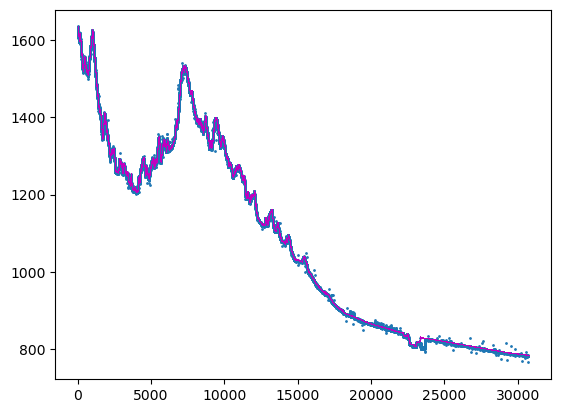

In [13]:
plt.scatter(gdf.alongtrack_XYZ,gdf.Z,s=1)
plt.plot(ground_laz.alongtrack_XYZ,ground_laz.Z,'m,');
# plt.scatter(ground_laz.alongtrack_XYZ,ground_laz.Z,c='m', s=0.1);
#plt.plot(max_min_envelope[:,1], c='r')
# plt.xlim(29000,31000);
# plt.ylim(750,830);
#plt.xlim(10000,10500);
#plt.ylim(1250,1340);

horizontally

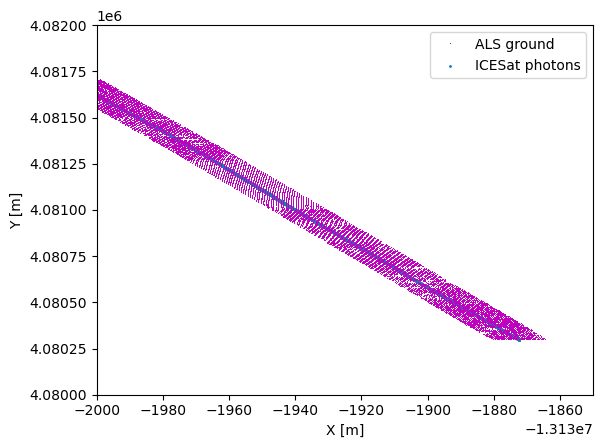

In [18]:
plt.plot(ground_laz.X,ground_laz.Y,'m,', label='ALS ground');
plt.scatter(xyz_icesat[:,0], xyz_icesat[:,1], s=1, label='ICESat photons');
plt.legend();
plt.xlim(-1.3132e7,-1.313185e7);
plt.ylim(4080000,4082000);
plt.xlabel('X [m]')
plt.ylabel('Y [m]');

show a subset of the first photons

In [19]:
subs = np.where(xyz_icesat[:,0] > -1.3132e7)[0]
subs2 = np.where(ground_laz.X > -1.3132e7)[0]

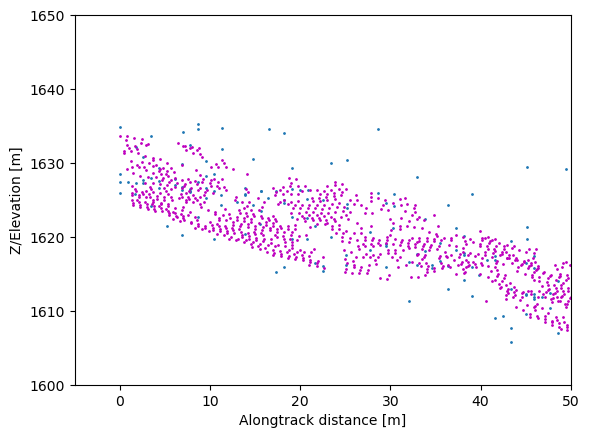

In [20]:
plt.scatter(xyz_icesat[subs,3], xyz_icesat[subs,2], s=1, label='ICESat photons');
#plt.scatter(xz_icesat[ground,0], xz_icesat[ground,1], s=2, c='k', label='ground photons')
plt.scatter(ground_laz.alongtrack_XYZ.iloc[subs2],ground_laz.Z.iloc[subs2],c='m',s=1, label='ALS ground');
plt.xlim(-5,50)
plt.ylim(1600,1650);
plt.xlabel('Alongtrack distance [m]')
plt.ylabel('Z/Elevation [m]');

## find ground

### 2D kdtree

In [21]:
# extracting ground truth photons in ICESat-2 based on the radius to ALS ground photons
ground = np.zeros(xz_icesat.shape[0], dtype="bool")
tree = spatial.KDTree(xz_icesat)
list = tree.query_ball_point(xz_als, r=0.6)
for l in list:
    ground[l] = True

print(np.sum(ground))

60278


### visualization

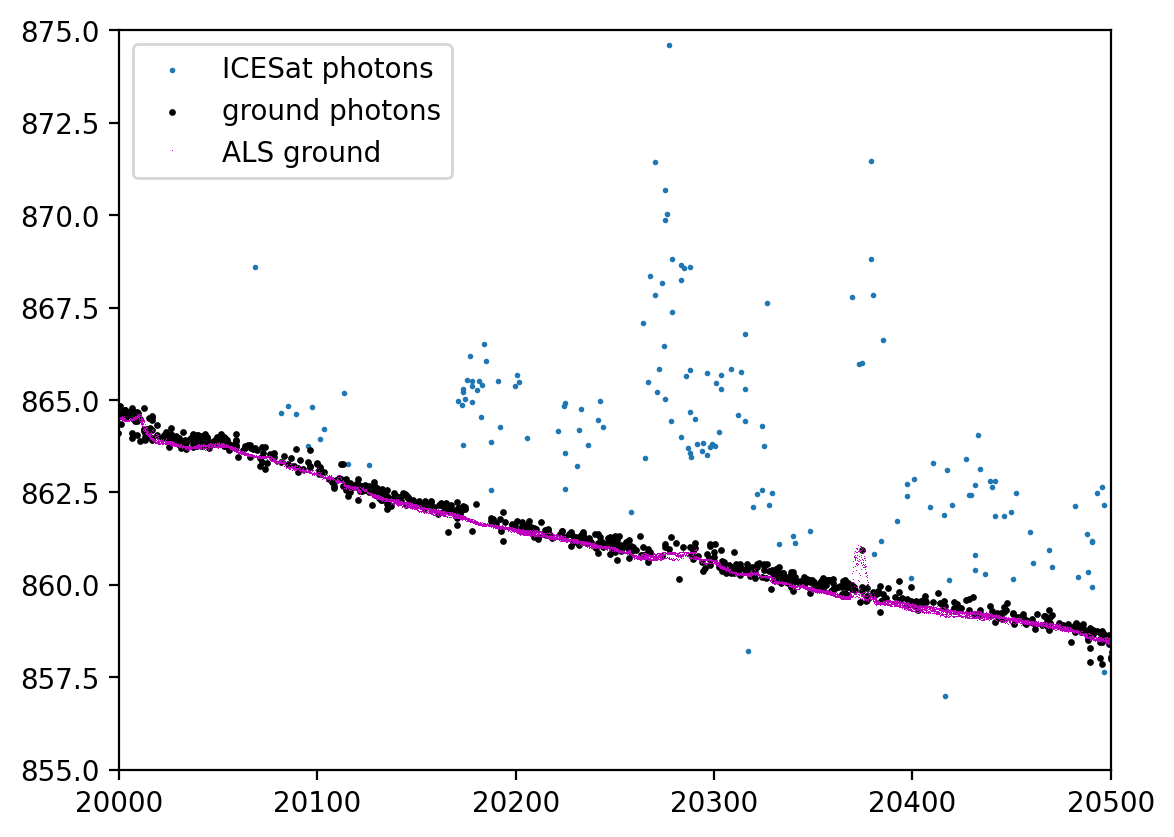

In [22]:
fig, ax = plt.subplots()
fig.set_dpi(200)
ax.scatter(xz_icesat[:,0], xz_icesat[:,1], s=1, label='ICESat photons');
ax.scatter(xz_icesat[ground,0], xz_icesat[ground,1], s=2, c='k', label='ground photons')
#ax.scatter(xz_icesat[ground05,0], xz_icesat[ground05,1], s=2, c='tab:green', label='ground photons 0.5')
#ax.scatter(ground_laz.alongtrack_XYZ,ground_laz.Z, s=1, alpha=0.1, label='ALS ground');
plt.plot(ground_laz.alongtrack_XYZ,ground_laz.Z,'m,', label='ALS ground');
ax.legend()
ax.set_xlim(20000,20500);
ax.set_ylim(855,875);
# ax.set_xlim(2000,2500);
# ax.set_ylim(1280,1360);

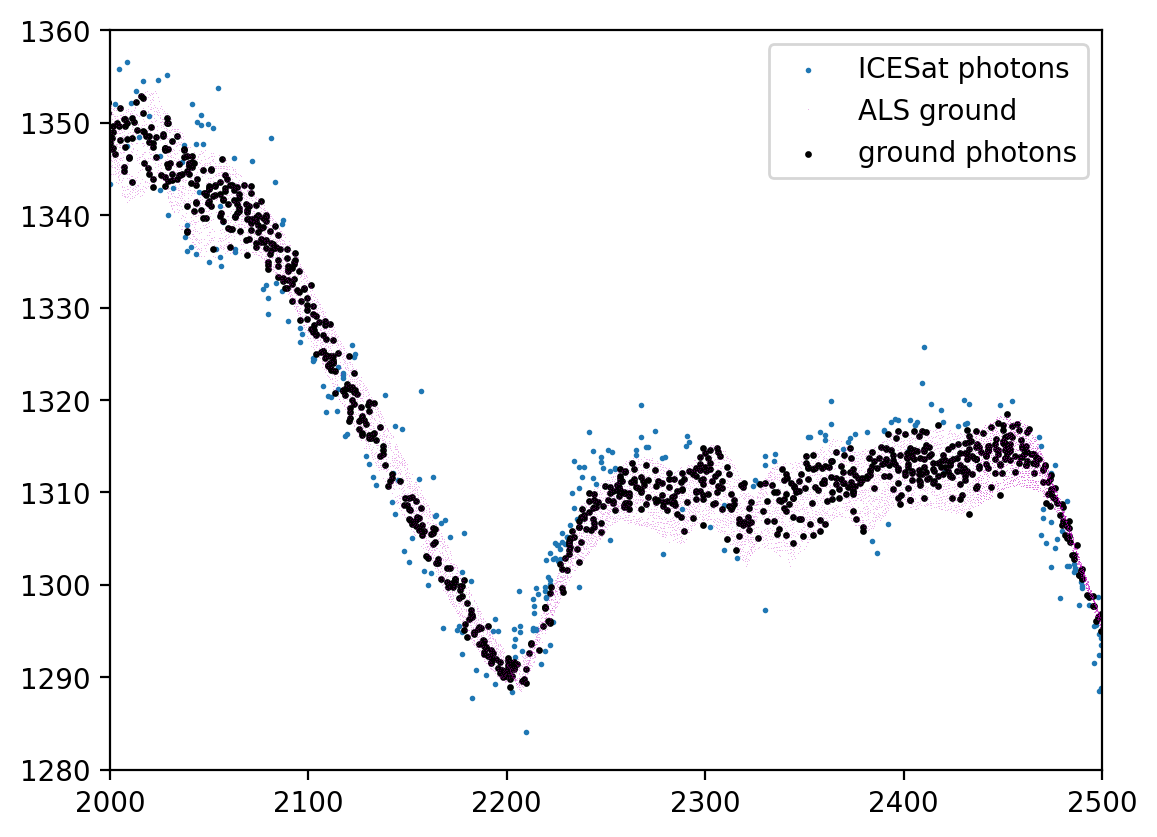

In [23]:
fig, ax = plt.subplots()
fig.set_dpi(200)
ax.scatter(xz_icesat[:,0], xz_icesat[:,1], s=1, label='ICESat photons');
plt.plot(ground_laz.alongtrack_XYZ,ground_laz.Z,'m,', alpha=0.3, label='ALS ground');
ax.scatter(xz_icesat[ground,0], xz_icesat[ground,1], s=2, c='k', label='ground photons')
ax.legend()
ax.set_xlim(2000,2500);
ax.set_ylim(1280,1360);

## save ground and icesat 2D point cloud

In [24]:
np.save('../data/ground/ML/ground_06_new.npy', np.where(ground == True)[0])

In [25]:
np.save('../data/ground/ML/xz_icesat_new.npy', xz_icesat)